# Pedestrian Detection using DETR and social distancing analysis with it

- Pedestrian detection is a key problem in computer vision, with several applications including robotics, surveillance and automotive safety.Formally pedestrian detection means automatically identifying and locating the pedestrians in images or videos. In this tutorial we'll detect pedestrian for surveillance purpose specifically for social distancing analysis with the help of facebook's
detection transfomer model. 

- **This kernel explains in detail how DETR (DEtection TRansformer) can be used for object detection for pedestrian detection task. You can use this kernel for training purposes with any custom datset**

<img src="https://www.researchgate.net/profile/Sudip-Das-16/publication/337831088/figure/fig1/AS:834110507474955@1575878850441/Pedestrian-detection-and-pose-estimation-results-of-ClueNet-on-an-image-sample-of.ppm">

- Transformers are a deep learning architecture that has gained popularity in recent years. They rely on a simple yet powerful mechanism called attention, which enables AI models to selectively focus on certain parts of their input and thus reason more effectively. Transformers have been widely applied on problems with sequential data, in particular in natural language processing (NLP) tasks such as language modeling  and  machine translation. Facebook released Detection Transformers (DETR) an important new approach to object detection and panoptic segmentation. DETR completely changes the architecture compared with previous object detection systems. It is the first object detection framework to successfully integrate Transformers as a central building block in the detection pipeline. DETR matches the performance of state-of-the-art methods, such as the well-established and highly optimized Faster R-CNN baseline on the challenging COCO object detection dataset, while also greatly simplifying and streamlining the architecture to a single stage detector.


- To understand in more detail what DETR model is refer the below links
 * 1. Paper: https://arxiv.org/abs/2005.12872 
 * 2. Github : https://github.com/facebookresearch/detr
 
 - The best way t follow along with the tutorial is kaggle. So i would suggest create an account on kaggle and just upload all the data which i will list below while explaining on kaggle and load them and you are good to go. And guess what you'll get gpu for free and you don't even have to install even python. Isn't that amazing. So that said let's dive into our problem

## 1. Importing necessary libraries 

- **Why do we need all these libraries i.e their use in general and in the context of our goal is explained below in brief and is also explained where they are used in below cells.** 
- numba :  It's an open-source JIT compiler that translates a subset of Python and NumPy into fast machine code using LLVM, via the llvmlite Python package this makes eh code run faster
- torch : It's an open source machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab. We will be using this for model creation and training purposes
- opencv : OpenCV is a library of programming functions mainly aimed at real-time computer vision. Here we'll use it for image processing like loading image, resizing, loading video feed data, and writing video.
- albumentations : Its a Python library for fast and flexible image augmentations. Albumentations efficiently implements a rich variety of image transform operations that are optimized for performance, and does so while providing a concise, yet powerful image augmentation interface for different computer vision tasks, including object classification, segmentation, and detection.Here we'll use it specifaclly for advanced augmentations which supports pytorch code.
- numpy,pandas,matplotlib,seaborn : for basic data crunching and analysis
- detr : cloning detr repo for importing the model and fine tuning it for pedestrian detection task


In [1]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
import sys
import numba  
from tqdm.autonotebook import tqdm

#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

#CV
import cv2

#Albumenatations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [2]:
# Seeding Everthing

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(21)

## 2. Dataset Description and How we'll use it

- Let's recall one more time that our goal is to create a pedestrian detection model. For any ML model it requires data. So based on our task our data should consist of image with people in it and the exact location of people should be localised via bounding box. Luckily we don't have to manually annotate the data by ourself. There are many benchmarked dataset for the task of pedestrian detection out of which we'll use INRIA and Oxford Town Centre dataset.

- INRIA dataset consist of 614 training images and 288 test images, classes and bounding box annotations for pedestrian detection in images. Dataset consists of train and test folders wherein each folder contains Annotations and JPEGimages as subfolders. Annotations consist of XML files which contains metadata for each image present in JPEGimage folder. Metadata consists of filename, width, height, bounding boxes coordinates. So we'll parse this metadata and create a dataframe of it so that we can use this dataframe to load images easily. The dataset can be downloaded from https://www.kaggle.com/datasets/jcoral02/inriaperson. We will use this data for training and validation purpose.
- The Oxford Town Centre dataset is a CCTV video of pedestrians in a busy downtown area in Oxford used for research and development of activity and face recognition systems. The CCTV video was apparently obtained from a surveillance camera at the corner of Cornmarket and Market St. in Oxford, England and includes approximately 2,200 people. Pedestrians appearing in the video act normally and unrehearsed suggesting that the images were captured without consent. Dataset can be downloaded from https://www.kaggle.com/datasets/ashayajbani/oxford-town-centre?select=TownCentreXVID.mp4 with name of video being TownCentreXVID.mp4. This video will be used for inference purpose and will also create a use case of pedestrain detection i.e once people are detected we will do a social distancing analysis ( people should maintain a distance of 2 feet from one another )

## Data Preparation 

- Since the inria dataset contains train and test folder and inside which we have the annotations of the bounding box for each image with the same id used for annotations and image. So we'll first parse the annotations and convert it into a dataframe and create train and valiadation dataframe. 
- Parsing means we will traverse each xml file and extract information namely filenames,widths,heights,xs,ys,ws,hs i.e bounding box coordinates 

## Parsing xml document 
- XML is an inherently hierarchical data format, and the most natural way to represent it is with a tree. ET has two classes for this purpose - ElementTree represents the whole XML document as a tree, and Element represents a single node in this tree. Interactions with the whole document (reading and writing to/from files) are usually done on the ElementTree level. Interactions with a single XML element and its sub-elements are done on the Element level. More information can be found here https://docs.python.org/3/library/xml.etree.elementtree.html
- Parsing logic
  - For each field that we need we extract the closest tag first and then locate the exact field
  - Each xml file contains size tag defining the image width and height
  - bndbox tag contains the bounding box description in xmin,ymin , xmax,ymax format i.e PASCAL VOC format
  - We need only these info for locating a person but we'll store annotations in COCO format i.e xmin.ymin , w,h since detr model uses this format

In [3]:
## Parsing XML files
import xml.etree.ElementTree as ET

def parse_xml(xml_files):
    error_files = []
    count = 0

    fnames,widths,heights,xs,ys,ws,hs = [],[],[],[],[],[],[]


    for i,img_ann in enumerate(xml_files):
        try:
            mytree = ET.parse(img_ann)
            myroot = mytree.getroot()

            # Image Name
            s = myroot[1].text
            ss = ".png"
            filename = s[:-(len(ss))]

            ## getting image width height
            for x in myroot.findall('size'):
                width,height = int(x[0].text),int(x[1].text)

            ## getting bounding box
            box = []
            objects = myroot[5:]

            for x in objects:
                xmin = int(x[4].find('xmin').text)
                ymin = int(x[4].find('ymin').text)
                xmax = int(x[4].find('xmax').text)
                ymax = int(x[4].find('ymax').text)
                w = xmax-xmin
                h = ymax-ymin
                bbox = [xmin,ymin,w,h]
                box.append(bbox)

        except Exception as _:
            print(f"An Error Ocurred for file {filename} ")
            error_files.append(filename)
        else:
            count+=1
            for XMIN,YMIN,W,H in box:
                fnames.append(filename)
                widths.append(width)
                heights.append(height)
                xs.append(XMIN)
                ys.append(YMIN)
                ws.append(W)
                hs.append(H)
    return fnames,widths,heights,xs,ys,ws,hs

In [4]:
## Loading all the xml documents and printing the length of train and validation df

train_xml = list(sorted(glob('../input/inriaperson/Train/Annotations/*.xml')))
val_xml = list(sorted(glob('../input/inriaperson/Test/Annotations/*.xml')))
print(f"Total Training Sample : {len(train_xml)}")
print(f"Total Validation samples : {len(val_xml)}")

## Creating dataframes based on the xml files

fnames,widths,heights,xs,ys,ws,hs = parse_xml(train_xml)
inria_train_df = pd.DataFrame({"image_id":fnames,"width":widths,"height":heights,"x":xs,"y":ys,"w":ws,"h":hs})

fnames,widths,heights,xs,ys,ws,hs = parse_xml(val_xml)
inria_val_df = pd.DataFrame({"image_id":fnames,"width":widths,"height":heights,"x":xs,"y":ys,"w":ws,"h":hs})


Total Training Sample : 614
Total Validation samples : 288


In [5]:
##  Checking sample of training dataframe
inria_train_df.head()

,image_id,width,height,x,y,w,h
0,crop001001,818,976,261,109,250,596
1,crop001001,818,976,31,326,178,386
2,crop001001,818,976,148,179,142,462
3,crop001002,1239,976,270,242,434,659
4,crop001002,1239,976,570,174,389,783


In [6]:
## Checking sample of validation dataframe
inria_val_df.head(5)

,image_id,width,height,x,y,w,h
0,crop001501,1060,605,250,151,49,143
1,crop001501,1060,605,215,354,59,112
2,crop001501,1060,605,568,320,39,113
3,crop001501,1060,605,829,180,52,141
4,crop001504,664,650,258,281,66,176


## Plotting a sample datapoint from training dataset and validation dataset
- For this task we will use matplotlib which is a plotting library and opencv for reading image files and also drawing rectangular bounding box around each person in the image data localising the pedestrians 

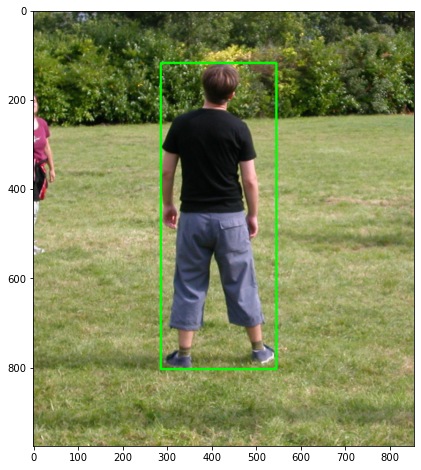

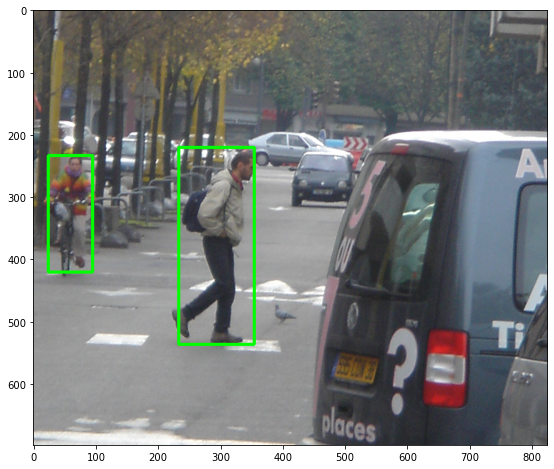

In [7]:
def plot_sample(df,path,img_id):
    fig = plt.figure(figsize=(10,8))
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    temp = df[df.image_id==img_id]
    box = np.array(temp.loc[:,["x","y","w","h"]])

    for b in box:
        x,y,w,h = b
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 3)

    plt.imshow(img);
    
train_sample_path =  "../input/inriaperson/Train/JPEGImages/crop001250.png"
plot_sample(inria_train_df,train_sample_path,"crop001250")

val_sample_path =  "../input/inriaperson/Test/JPEGImages/crop001531.png"
plot_sample(inria_val_df,val_sample_path,"crop001531")

- Since the dataframe is loaded properly as verified above by some sample datapoints from both training and validation dataframe. Lets save our dataframe so we don't loose it

In [8]:
## Saving the dataframes
inria_train_df.to_csv("train.csv",index=False)
inria_val_df.to_csv("val.csv",index=False)

## Bounding Box formats
- There are various bounding box formats but the important ones which we need to know is that INRIA dataset gives bounding box in xmin,ymin,xmax,ymax (pascal_voc) format to which we converted into xmin_ymin,w,h (COCO format) but DETR model requires it in centerx,centery,w,h in normalised format hence these below utility functions will help us to interchange between these formats.
- Since DETR uses cx,cy,w,h format in the research paper and pytorch and albumentation uses coco format to support these interchanges the below function will help

- To understand it refer below image

The image width is 640 pixels, and its height is 480 pixels. The width of the bounding box is 322 pixels, and its height is 117 pixels.

The bounding box has the following (x, y) coordinates of its corners: top-left is (x_min, y_min) or (98px, 345px), top-right is (x_max, y_min) or (420px, 345px), bottom-left is (x_min, y_max) or (98px, 462px), bottom-right is (x_max, y_max) or (420px, 462px). As you see, coordinates of the bounding box's corners are calculated with respect to the top-left corner of the image which has (x, y) coordinates (0, 0).

<img src="https://albumentations.ai/docs/images/getting_started/augmenting_bboxes/bbox_example.jpg">


- To learn more about it refer below : https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

In [9]:
def convert_to_cxcywh(bboxes,size=512): 
    """A utility function to convert bounding boxes to normalized (center_x, center_y, w, h) format.
    It expects the input bboxes in (x_min, y_min, w, h) format."""
    
    box = np.array(bboxes)
    xy , wh = box[:,[0,1]] , box[:,[2,3]]
    xy = xy+wh/2
    xcycwh = np.concatenate((xy,wh),axis=1)
    
    # normalizing
    xcycwh = xcycwh/size
    return xcycwh

def convert_to_xmin_ymin_wh(bboxes,size):
    """A utility function to convert bounding boxes to (x_min, y_min, w, h) format.
    It expects the input bboxes in normalized (center_x, center_y, w, h) format."""
    
    box = np.array(bboxes)
    xy , wh = box[:,[0,1]] , box[:,[2,3]]
    xy = xy-(wh/2)
    xywh = np.concatenate((xy,wh),axis=1)
    
    # denormalizing
    xywh = xywh*size
    return xywh

## Data Loading and Preprocessing
- Since the dataframe created above consists of filename of the image and bounding box , now we would actually like to load these files into memory so that we can feed it to our model for training. There are numerous ways via which we can load the dataset but we will follow the standard approach of pytorch framework to extend dataset class by implementing the standard functions of DataSet class namely __init__, __getitem__ and __len__
- __Explaination of how Dataset class works__
  - __init__ : standard constructor wherein we create variables that we'll need in our case we initialise our dataframe i.e train or val , dir_path of the files i.e Train for train and Test for val , all imageids or filename that we will load and finally transforms ( we'll understand this in a moment) for preprocessing
  - __len__ : It will return the length of total data
  - __getitem__ : to support the indexing such that image_ids[i] can be used to get ith sample. Given an index ot loads ith image_ids sample applies preprocessing and returns the image
  



- To understand in more detail about dataloading in pytorch refer this: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [10]:
class INRIA_Dataset(Dataset):
    
    def __init__(self,image_ids,dataframe,dir_path,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms  
        self.dir_path = dir_path
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        
        # reading the input image and normalizing
        image = cv2.imread(f'{self.dir_path}/{image_id}.png', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
         
        boxes = records[['x', 'y', 'w', 'h']].values
        
        # calculating area of the bounding box
        area = boxes[:,2]*boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # DETR works better if the main class is labelled as zero
        labels =  np.zeros(len(boxes), dtype=np.int32)

        # applying the tranforms
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
            
        # normalizing the bounding boxes by image height    
        _,h,w = image.shape
        boxes = convert_to_cxcywh(boxes,h) # h = w
        
        # creating a target dictionary
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        
        return image, target, image_id
    

# returns image in batches 
def collate_fn(batch):
    return tuple(zip(*batch))

## 5.2 PreProcessing / Augmentations : transformations to be applied on training images
- Since we have image data and total training samples are within 1000 our model will not be able to capture real time variations like light intensity, distortedness, blur, noise, occlusion,etc. To simulate real life scenarios and also to make extra samples from the available samples we will apply augmentations so that our model is roubust and generalizes better
- For this purpose we'll use albumentations which is a pytorch library which makes advanced augmentations and even multiple at once by just specifying the name of augmentation and probability of it being applied on each image 
- So first we group similar type of augmentations together like RandomBrightness and RGBShift and then provide probability that for a given image it should be applied 100% and adding all such groups in compose function provided by albumentation
- At the end we specify the bbox format so when the image is changed it's bbox is preserved and since we're using coco format we pass coco
- To understand more about it refer https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

In [11]:
def get_train_transforms():
    return A.Compose([   
            
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=0.2,  
                                           contrast_limit=0.2, p=0.3),
                A.RGBShift(r_shift_limit=20/255, g_shift_limit=20/255, b_shift_limit=10/255,p=0.3),
                    ], p=0.2) ,
            
            
            A.OneOf([
                A.Blur(p=0.6),
                A.GaussNoise(var_limit=(0.01, 0.05), mean=0, p=0.05),
                A.ToGray(p=0.05)], p=0.2) ,
            A.OneOf([
                A.HorizontalFlip(p=0.5),   
                A.Transpose(p=0.5),                
                A.RandomRotate90(p=0.5)], p=1),         
             A.Resize(height=HEIGHT, width=WIDTH, p=1),
             ToTensorV2(p=5.0),
             ],
             
        p=1.0, bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
    )

# validation image are for testing purposes hence we don't apply augmentataions here only resize
# the image and converting it to tensor format
def get_valid_transforms():
    return A.Compose(
            [
                A.Resize(height=HEIGHT, width=WIDTH, p=1.0),
                ToTensorV2(p=1.0)
            ], 
              p=1.0, 
              bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
    )

**We are done with data loading and preprocessing and now we'll move towards modelling**

# Creating Model
- Since we're going to use DEtection TRansformer (DETR) model we'll need the detr's github repositories because all the code files will be present there 
- Our task is to take their detr model class and extend it to do transfer learning for pedestrian detection task but before that let's understand briefly how detr model works

## Understanding DETR Architecture 

* The main ingredients of the new framework, called DEtection TRansformer or DETR, are a set-based global loss that forces unique predictions via bipartite matching, and a transformer encoder-decoder architecture.
* Given a fixed small set of learned object queries, DETR reasons about the relations of the objects and the global image context to directly output the final set of predictions in parallel.
* Set Prediction : The usual solution is to design a loss based on the Hungarian algorithm to find a bipartite matching between ground-truth and prediction. This enforces permutation-invariance and guarantees that each target element has a unique match.
* Transformers and Parallel Decoding :  Transformers and parallel decoding are combined for their suitable trade-off between computational cost and the ability to perform the global computations required for set predict.

### Overall DETR architecture contains the following 3 components:
* A CNN backbone to extract compact feature representation : It provides us the positional encoding before passing it to the transformer encoder.
* An encoder-decoder transformer : A transformer decoder takes as input a small fixed number of learned positional embeddings, which we call object queries, and additionally attends to the encoder output.
* A FFN (Feed Forward Network) that makes the final decision prediction : We pass each output embedding of the decoder to a shared FFN that predicts either a detection (class and bounding box) or a “no object” class.

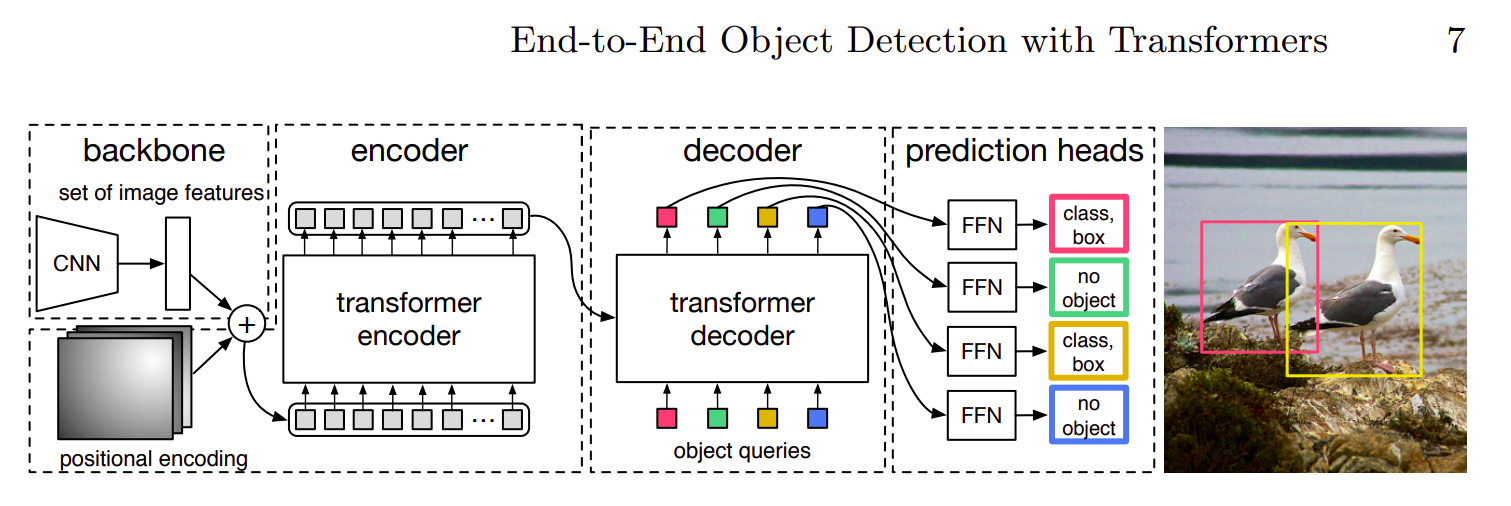

## Model Creation 
- Step 1 : Cloning the detr github repository 
- Step 2 : Creating DETR model class with intialisation like 
    - num_classes : total classes to look for n our case we need person and the null class is background hence 2
    - num_queries : total queries asked by encoder i.e total number of predictions set to 100. It is a customisable varable set to maximum objects that can be detected in a frame. Here we assume that the maximum person that can be detected in a image is 100
    - model : DETR model which is pretrained on resnet_50 backbone
   
#### So now our model is customised for pedestian detection task with total class as 2 hence the output generated by model will contain now only two classes ie person or background

In [12]:
# cloning detr's github repository
!git clone https://www.github.com/facebookresearch/detr.git

Cloning into 'detr'...
remote: Enumerating objects: 260, done.
remote: Total 260 (delta 0), reused 0 (delta 0), pack-reused 260
Receiving objects: 100% (260/260), 12.85 MiB | 18.05 MiB/s, done.
Resolving deltas: 100% (142/142), done.


## Lets define all model related constants like
- batch size 
- num_classes : i.e person and background
- num_queries : no of input queries for each image (refer dter paper to understand more)    
- WIDTH = HEIGHT all images will be resized to this dimension
- num_epochs
- learning rate 

In [13]:
# Model Configuration
num_classes = 2 # person + background class
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 16
LR = 2e-5 
EPOCHS = 2
WIDTH = HEIGHT = 512

In [14]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        
        # inheriting the DETRModel class from detr's github repo
        super().__init__()
        
        # changing parameters according to our dataset
        
        self.num_classes = num_classes # also includes background class
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

## Defining Different utililty functions and classes needed while training

### Defining the metric used for training as mean average precision
- To evaluate our model we need some metric and we will use the standard metric used for object detection task i.e mean average precision
- Usually, the object detection models are evaluated with different IoU thresholds where each threshold may give different predictions from the other thresholds. To calculate the mAP, start by calculating the AP for each class. The mean of the APs for all classes is the mAP.
- To understand more about it refer the following link https://blog.paperspace.com/mean-average-precision/
- Currently we're using only 0.5 threshold but if we need more that can be appended to the iou_thresholds list

In [15]:
## script whch we will use for calculating mean average precision
sys.path.append('/kaggle/input/mean-average-precision/')
import mAP

# different iou thresholds to calculate mAP
iou_thresholds = numba.typed.List()
for x in [0.5]:
    iou_thresholds.append(x)
iou_thresholds

def calculate_final_score(all_predictions, score_threshold,form):
    """A function that calculates mAP of the model using the diffferent thresholds provided"""
    
    final_scores = []
    for i in range(len(all_predictions)):
        gt_boxes = all_predictions[i]['gt_boxes'].copy()
        pred_boxes = all_predictions[i]['pred_boxes'].copy()
        image_precision = mAP.calculate_image_precision(gt_boxes, pred_boxes,thresholds=iou_thresholds,form=form)
        final_scores.append(image_precision)

    return np.mean(final_scores)

## Averaging Bath Computation
- Since we do batchwise training in DL we need to calculate the average score for the batch for that purpose the below class accumulates the batch wise accuracy, loss , score to it's mean 

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Defining The loss for our detr model
- Detr uses hungarian matcher and generialised iou loss and for all this purpose the SetCriterion class found in detr/models/dter.py helps to calculate all these. It takes input as num_classes matcher, weight_dict,  losses i.e which losses do we need -> we pass labels and boxes as we need bbox loss and classification loss. For more understanding refer the detr github files specifically detr/models/matcher.py and detr/models/detr.py


## Before that let's understand in brief about DETR losses

* The Bipartite Matching Loss produces an optimal bipartite matching between predicted and ground truth objects and then optimize object-specific (bounding-box) losses. To find a Bipartite Matching between the predicted and ground truth object, permutations of N elements is searched for with the lowest loss.
* The optimal assignment is computed using the **Hungarian Algorithm**. We need to find one-to-one matching for direct set prediction without duplicates. This is done by using the **Hungarian Matcher**. It is a linear combination of a negative-log likelihood for class prediction and a box loss. 
* The most commonly used l1 loss will have different scales for small and large bounding boxes even if the relative errors are similar. To mitigate this issue a linear combination of the l1 loss and the generalized IoU loss is used.
* For an in depth understanding of the HHungarian Algorithm checkout the following link : 
https://en.m.wikipedia.org/wiki/Hungarian_algorithm

## 5.6 Defining the loss


In [17]:
# Files which contains loss function 
# We are appending the path of detr folder that we just cloned so that 
# python interpreter knows where to search for matcher.py and detr.py files

sys.path.append('./detr')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion

matcher = HungarianMatcher()

# assigning weights to each loss , these are as specified by the detr paper 
# for more understanding I would recommend to read the paper and refer SetCriterion class
weight_dict = {'loss_ce': 0.5, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

## Training Function for each batch
1. We first enter into training mode i.e we will cache the forwrad propagations values that will help in backward prop
2. For each metric we call the average class that we defined above to accumulate the score for each 
3. We first push our data to device i.e GPU for fast compuatation
4. We do a forward propogataion
5. Calculating loss for the batch
6. Update weights by backpropogating the loss
7. Displaying the average loss and scores for the current batch

In [18]:
MODEL_NAME = "DETR_Pedestrian_Detection"

def train_fn(data_loader, model,criterion, optimizer,device, scheduler, epoch, valid_data_loader):
    """Function used to train the model for specified number of epochs."""
    
    # entering training mode
    model.train()
    criterion.train()
    
    # average class for each metric 
    total_loss = AverageMeter()
    bbox_loss = AverageMeter()
    giou_loss = AverageMeter()
    labels_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets, image_ids) in enumerate(tk0):

        # pushing data on gpu 
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        
        output = model(images)

        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict

        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        # setting the gradients to zero 
        # before computing the new gradients as they get added with the previous gradients.
        optimizer.zero_grad()

        # computing the gradients.
        losses.backward()

        # taking a step in the direction of the gradients.
        optimizer.step()

        # learning rate scheduler
        if scheduler is not None:
            scheduler.step()

        # accumulating the loss and cores 
        total_loss.update(losses.item(),BATCH_SIZE)
        bbox_loss.update(loss_dict['loss_bbox'].item())
        giou_loss.update(loss_dict['loss_giou'].item())
        labels_loss.update(loss_dict['loss_ce'].item())

        # following losses will be displayed while training
        tk0.set_postfix(
            bbox_loss=bbox_loss.avg,
            giou_loss = giou_loss.avg,
            labels_loss = labels_loss.avg,
            total_loss=total_loss.avg
        )
        
    return total_loss,bbox_loss,giou_loss,labels_loss

## 5.8 Evaluation Function for model
- Once we have done a training epoch we need to evaluate our model on validation set but now we only need to do forward propagation and we do not require to do gradient computation hence we the only difference in eval_fn and train_fn above is that here we enter into eval mode 
- Then for each predicted output we store the ground truth bbox and predicted so that we can calculate mAP score 

In [19]:
def eval_fn(data_loader, model, criterion, device):
    """Function used to evaluate the model"""
    
    model.eval()
    criterion.eval()
    all_predictions = []
    
    total_loss = AverageMeter()
    bbox_loss = AverageMeter()
    giou_loss = AverageMeter()
    labels_loss = AverageMeter()
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # taking outputs from the model
            output = model(images)
        
            
            
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            # updating the losses
            total_loss.update(losses.item(),BATCH_SIZE)
            bbox_loss.update(loss_dict['loss_bbox'].item())
            giou_loss.update(loss_dict['loss_giou'].item())
            labels_loss.update(loss_dict['loss_ce'].item())
            
            # the following losses will be displayed while trainign.
            tk0.set_postfix(
                bbox_loss = bbox_loss.avg,
                giou_loss = giou_loss.avg,
                labels_loss = labels_loss.avg,
                total_loss=total_loss.avg
            )
               
            ## Storing output in all_predictions so that we can use it later to calculate MAP
            for i in range(len(images)):
                
                # detr returns predictions in the form of a dictonary. Accessing individual predictions
                boxes = output['pred_boxes'][i].detach().cpu()
                scores = output['pred_logits'][i].softmax(1).detach().cpu().numpy()[:,0]
                gt_boxes = targets[i]['boxes'].cpu()
                
                _,h,w = images[i].shape
                
                # Converting normalized (center_x,center_y, w, h) format to denormalized (x_min,y_min, w, h)
                boxes = convert_to_xmin_ymin_wh(boxes,h) 
                gt_boxes = convert_to_xmin_ymin_wh(gt_boxes,h) 
                
                boxes = np.array([[x,y,w,h] for x,y,w,h in boxes]).astype(np.int32) # since h = w
                gt_boxes = np.array([[x,y,w,h] for x,y,w,h in gt_boxes]).astype(np.int32)
            
                all_predictions.append({
                    'pred_boxes': boxes,
                    'scores': scores,
                    'gt_boxes': gt_boxes,
                    'image_id': image_ids[i],
                })        

    return all_predictions,total_loss,bbox_loss,giou_loss,labels_loss

## 5.9 Run function for each epoch 
- Now all the functions written above will help in training first we'll create dataset class for training and evaluation and then create dataloader based on these classes. Once we have our dataloader next step is to load the model , its loss class and create an appropriate optimizer for backward propagation in our case i.e Adam Optimizer. Once e have all these set for all epochs we'll call train and eval function above which will give us the scores and losses and predictions which we'll log into the files for plotting purpose and based on the mAP whenever our score increases we save our model

Step by Step the Process is given below:
- Instantiating Dataset class for training and validation images
- loading training images batch-wise
- instantiating DETRModel class
- Instantiating the optimizer i.e Adam Optimizer along with SetCriterion class to calculate loss
- Calling train and eval function written above
- Logging the losses and scores
- Storing best model based on map score


- I have trained the model and loading that and running it only for two epochs in case you are training it for the first time run for as many epochs as you please but its better to run not more than 80 epochs in my opinion

In [20]:
cv_score = list()
def run():
    
    train_dataset = INRIA_Dataset(
    image_ids = inria_train_df["image_id"].unique(),
    dataframe = inria_train_df,
    transforms = get_train_transforms(),
    dir_path = "../input/inriaperson/Train/JPEGImages"   
    )

    valid_dataset = INRIA_Dataset(
    image_ids = inria_val_df["image_id"].unique(),
    dataframe = inria_val_df,
    transforms = get_valid_transforms(),
    dir_path = "../input/inriaperson/Test/JPEGImages"
    )
    
    # loading training images batch-wise
    train_data_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 4,
    collate_fn = collate_fn
    )

    # loading validation images batch-wise
    valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
    )
    
    print(f'TrainDataLen = {len(train_data_loader)} || ValDataLen = {len(valid_data_loader)}\n\n')
    
    # setting device to gpu
    device = torch.device('cuda')
    
    # instantiating DETRModel class
    model = DETRModel(num_classes=num_classes,num_queries=num_queries)
    model = model.to(device)
    
    
    ## Loading a pretrained model which I have trained earlier on comment these two lines if 
    ## you are training for the first time else give the path of your trained model
    WEIGHTS_FILE = "../input/oxford-town-centre/detr_best.pth"
    model.load_state_dict(torch.load(WEIGHTS_FILE))
    
    # We cannot pass the background class to SetCriterion hence, num_classes - 1 is the parameter value passed to it.
    criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
    criterion = criterion.to(device)
    
    # optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    
    mapScore =  -1
    
    with open("./model.log", "a") as f:
        # training for a given number of epochs
        for epoch in range(EPOCHS):
            total_loss,bbox_loss,giou_loss,labels_loss = train_fn(
                train_data_loader,
                model,criterion, 
                optimizer,device,
                scheduler=None,
                epoch=epoch,
                valid_data_loader = valid_data_loader
            )

            predictions,vtotal_loss,vbbox_loss,vgiou_loss,vlabels_loss = eval_fn(valid_data_loader, model,criterion, device)
            valid_map_score = calculate_final_score(predictions,0.5, form = 'coco')

            
            print('|EPOCH {}| TRAIN_LOSS {}| vtotal_loss {}| VALID_MAP_SCORE {}|'.format(epoch+1,total_loss.avg,vtotal_loss.avg,valid_map_score))
            
            
            ## Logging Files
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
            f.write(f"{MODEL_NAME}_{current_time},{round(time.time(),3)},{total_loss.avg},{bbox_loss.avg},{giou_loss.avg},{labels_loss.avg},{vtotal_loss.avg},{vbbox_loss.avg},{vgiou_loss.avg},{vlabels_loss.avg},{valid_map_score},{(epoch+1)}\n")

            
            # saving the best model
            if valid_map_score > mapScore:
                mapScore = valid_map_score
                print('Best model found in Epoch {}........Saving Model'.format(epoch+1))
                torch.save(model.state_dict(), f'detr_best.pth')
                cv_score.append(valid_map_score)
                
    return model

In [21]:
%time
detr = run()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
TrainDataLen = 39 || ValDataLen = 18




Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth



|EPOCH 1| TRAIN_LOSS 0.375446570225251| vtotal_loss 0.25668978856669533| VALID_MAP_SCORE 0.020393774671584805|
Best model found in Epoch 1........Saving Model



|EPOCH 2| TRAIN_LOSS 0.35338497926027346| vtotal_loss 0.2506480995151732| VALID_MAP_SCORE 0.020392658501287027|


## Inference
- Here we will use the best saved model , so first load it from the path where you saved. If you are following on kaggle the path would be in output directory. So let's load the saved model in evaluation mode as we only need to do predictions over here.

In [25]:
WEIGHTS_FILE = "../input/detr-best/detr_best.pth"

# instantiating the model
model = DETRModel(num_classes=num_classes, num_queries=num_queries)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# loading trained weights for predictions
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.eval()
print("Model Loaded Successfully")

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


Model Loaded Successfully


## Inference on oxford town centre
- So as dicussed in the data section we will use oxford town centre dataset for evaluation so download it and save it as a dataset in kaggle and then give its required path. So here we will check whether the video is loading properly or not and display its some of major informations like framecount and fps, etc

In [26]:
path = "../input/oxford-town-centre/TownCentreXVID.mp4"
cap = cv2.VideoCapture(path)
print(f'Frame Width:{cap.get(cv2.CAP_PROP_FRAME_WIDTH)}')
print(f'Frame Height:{cap.get(cv2.CAP_PROP_FRAME_HEIGHT)}')
print(f'Frame Rate:{cap.get(cv2.CAP_PROP_FPS)}')
print(f'Frame Count:{cap.get(cv2.CAP_PROP_FRAME_COUNT)}')
print(f'Frame Position:{cap.get(cv2.CAP_PROP_POS_FRAMES)}')
print(f'Total Length of Video:{cap.get(cv2.CAP_PROP_FRAME_COUNT)/cap.get(cv2.CAP_PROP_FPS)}s')

Frame Width:1920.0
Frame Height:1080.0
Frame Rate:25.00333288894814
Frame Count:7502.0
Frame Position:0.0
Total Length of Video:300.04s


## Function for social distancing analysis 
- First lets create a frames directory which will store the output of the model. Since its a video we will load each frame one by one then run the model over it to get bounding box predictions and then 
- Calculate the distance between each bounding box if it is less than threshold then mark them as they are breaking social distancing norms by marking them in red bounding box

In [43]:
! rm -rf frames
! mkdir frames
! ls -l

from torch import nn
import torchvision.transforms as T

transform = T.Compose([T.ToTensor()])
oparray = list()

## Compute the distance matrix
def compute_distance(bboxes_person,midpoint,threshold=100):
    size = bboxes_person.shape[0]
    violate = set()
    for i in range(size):
        for j in range(i+1,size):
            pointi = np.array(midpoint[i])
            pointj = np.array(midpoint[j])
            dist = np.linalg.norm(pointi-pointj)
            if dist<threshold:
                violate.add(i)
                violate.add(j)
        
    return violate


def getOutput(img,social_distancing,cnt):
    
    train_img = transform(img).unsqueeze(0)

    output=None
    with torch.no_grad():
        output = model(train_img.to(device,dtype=torch.float))
    
    softmax = nn.Softmax(dim=1)
    probability = output["pred_logits"][0].softmax(1).detach().cpu().numpy()[:, 0].round(3)
    bboxes = convert_to_xmin_ymin_wh(output["pred_boxes"][0].detach().cpu(),WIDTH)
    threshold = 0.1
    indexes = np.where(probability>threshold)
    bboxes_person = bboxes[indexes]
    probability = probability[indexes]
    
    
    ## Midpoint
    midpoint = []
    
    for i,box in enumerate(bboxes_person):
        ## Midpoint
        x,y,w,h = box
        mid = [x+w//2,y+h//2]
        midpoint.append(mid)
        
    ## Get The distance matrix
    violate = compute_distance(bboxes_person,midpoint,75)
    total_person_detected = len(bboxes_person)
    total_violations = len(violate)
    
    for i,box in enumerate(bboxes_person):
        xmin,ymin,w,h = box.tolist()
        xmax,ymax = xmin+w,ymin+h
        xmin,ymin,xmax,ymax = int(xmin),int(ymin),int(xmax),int(ymax)
        
        
        if i in violate:
            cv2.rectangle(social_distancing,(xmin,ymin),(xmax,ymax),(0, 0, 255), 2)
            #cv2.putText(social_distancing,str(i),(xmin+w//2,ymin),font,fontScale ,fontColor,lineType) 
        else:
            cv2.rectangle(social_distancing,(xmin,ymin),(xmax,ymax),(0, 255, 0),2)
    
    social_distancing = cv2.cvtColor(social_distancing,cv2.COLOR_BGR2RGB)
    cv2.imwrite("./frames/op"+str(cnt)+".png",social_distancing)
    #oparray.append(social_distancing)
    return social_distancing
    

total 163476
---------- 1 root root       263 Apr 26 02:10 __notebook_source__.ipynb
drwxr-xr-x 9 root root      4096 Apr 26 02:11 detr
-rw-r--r-- 1 root root 166537190 Apr 26 02:12 detr_best.pth
drwxr-xr-x 2 root root      4096 Apr 26 02:25 frames
-rw-r--r-- 1 root root       462 Apr 26 02:12 model.log
-rw-r--r-- 1 root root    770836 Apr 26 02:24 prediction.mp4
-rw-r--r-- 1 root root     43632 Apr 26 02:11 train.csv
-rw-r--r-- 1 root root     21587 Apr 26 02:11 val.csv


## Reading and writing video in frames
- Reading and writing videos in OpenCV is very similar to reading and writing images. A video is nothing but a series of images that are often referred to as frames. So, all you need to do is loop over all the frames in a video sequence, and then process one frame at a time. In this post, we will demonstrate how to read, display and write videos from a file, an image sequence and a webcam. 
- We will load the video frame by frame and for each frame calculate output and store it in the frame directory. To do this we use opencv which helps in loading video as frames using the videoCapture api which looks like below. 
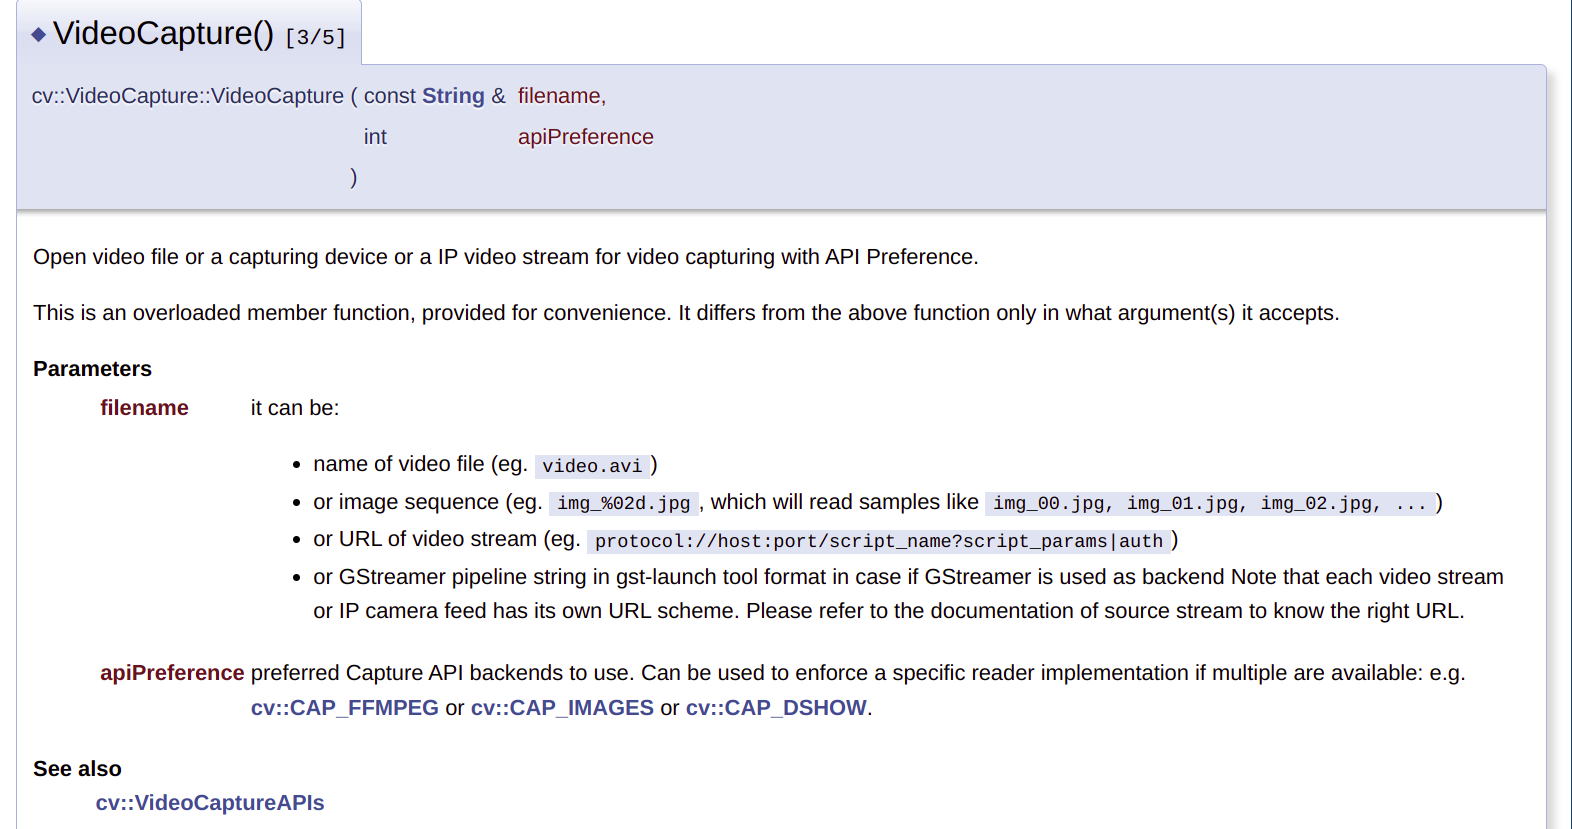

- To understand more about it refer : https://learnopencv.com/reading-and-writing-videos-using-opencv/

path is ../input/oxford-town-centre/TownCentreXVID.mp4
MInInf is 0.04934573173522949sec
Time elapsed is 63.26640057563782 second or 1.0544 min
Mean Inference is 0.054982959416500596


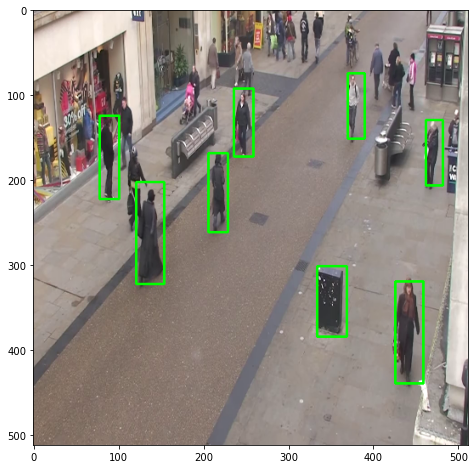

In [46]:
## Reading video and calculating output

import time

print(f'path is {path}')
cap = cv2.VideoCapture(path)
cnt=-1

minInf = 1000
infSum = 0

s = time.time()

while(cap.isOpened()):
    # Capture frame-by-framea
    start = time.time()
    ret, img = cap.read()
    
    
    if ret == True:
        cnt+=1
        
        if cnt>=500 and cnt<=1606:
            # Preprocessing and Calliberation
            img = cv2.resize(img,(512,512))
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            social_distancing = img.copy()
            img = img/255.0
            getOutput(img,social_distancing,cnt)
            
            inf = time.time()-start
            infSum+=inf
            minInf = min(inf,minInf)
            #print(f'FrameNo{cnt+1} InferenceTime={inf}sec')

    
    if cnt==1606:
        e = time.time()
        print(f'MInInf is {minInf}sec')
        print(f"Time elapsed is {(e-s)} second or {round((e-s)/60,4)} min")
        print(f'Mean Inference is {(infSum/(1607-500))}')
        cap.release() 
        plt.figure(figsize=(12,8))
        plt.imshow(social_distancing);
        break

- Let’s now take a look at how to write videos. Just like video reading, we can write videos originating from any source in our case the frames stored in frame directory (a video file, an image sequence, or a webcam). To write a video file: 

- Retrieve the image frame height and width Initialize a video capture object (as discussed in the previous sections), to read the video stream into memory, using any of the sources previously described. Create a video writer object. Use the video writer object to save the video stream to disk. 

In [47]:
## Writing video and storing output

op_frames = os.listdir('./frames')
op_frames.sort(key=lambda x:int(x.split('.')[0][2:]))

%time
s = time.time()

frame_array=[]
size = None
for i in range(len(op_frames)):
    
    #reading each files
    img = cv2.imread('./frames/'+op_frames[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)
    


out = cv2.VideoWriter('prediction.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 18, size)#filename,fourcc,fps,img_size
 
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

e = time.time()
print(f"Time elapsed is {(e-s)} second or {round((e-s)/60,4)} min")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs
Time elapsed is 12.850260496139526 second or 0.2142 min
